# 初期化

今回はNNを初期化する手法を確認します。  
NNが深くなるほど、ネットワークを通して安定的な勾配を伝播させることが重要になります。そうしないと、勾配が消滅したり爆発したりする可能性があるためです。そのため、今回は重みの初期化に関して見ていきます。

In [1]:
import os
import json
import math
import japanize_matplotlib
import numpy as np 
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        # GPUありの場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    elif torch.backends.mps.is_built():
        device = torch.device("mps:0")
    else:
        device = torch.device("cpu")
    return device

In [3]:
# pytorchでデータをダウンロードするときのパス（重複してDWしないため）
DATASET_PATH = "../data"
# モデルの保存先
CHECKPOINT_PATH = "../models/04_initialization"
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# 再現性のためにseedを固定する
set_seed(42)

# device情報を取得する
device = get_device()
print(f"deviceは{device}です")

deviceはmps:0です


### 準備

まずは、今回使用するデータとネットワークを準備します。前回のコードと同じです。

In [9]:
class BaseNetwork(nn.Module):
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - 今回試したい活性化関数
            input_size - 画像のサイズ
            num_classes - 予測したいクラス数
            hidden_sizes - 隠れ層のサイズのリスト
        """
        super().__init__()
        
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn()]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # リスト情報からlayerを追加
        self.layers = nn.Sequential(*layers)
        
        # モデルを保存/読み込む際に必要な情報を格納
        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        # ここで、画像を１次元へ変換
        x = x.view(x.size(0), -1)
        out = self.layers(x)
        return out    

In [6]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# __getitem__()で取得する各画像に対して行う変換。ここではTensor化と正規化
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.2861,), (0.3530,))])

# 訓練データのダウンロードとデータの分割
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# テストデータのダウンロード
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# DataLoaderの定義
# 実際のより大きな画像/モデルの場合はbatch_sizeはメモリに制限があり、より少なく設定されると思われます
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

次に、活性化関数を準備します。ここでは、前回とは異なりpytorchのモジュールを使用します。

In [7]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": nn.Identity
}

色々な可視化を行う関数を準備します。前回と同様の関数になります。

In [14]:
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig
 
##############################################################

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()
    
    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
##############################################################
    
def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()
    
    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()
    
    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")

            
##############################################################

### 初期化

ニューラルネットワークを初期化する際、重要なポイントが２点あります。  
1. 入力の分散はモデルを通して最終層まで伝搬し、出力ニューロンが同様の標準偏差を持つようにする必要があります。もし分散がモデルの深部に行くほど消滅するなら、次の層への入力は基本的に単一の定数値であるため、モデルを最適化することが非常に難しくなリます。同様に、分散が増加する場合、モデルを深く設計すればするほど、分散は爆発する（すなわち、無限大に向かう）可能性が高くなります。
2. 層間で分散が均等な勾配分布であることです。もし最初の層が最後の層よりずっと小さな勾配を受け取るなら、適切な学習率を選択することが難しくなります。

ここで、最初の議論として簡単にするために、活性化関数に恒等関数を使用します。

In [11]:
model = BaseNetwork(act_fn=nn.Identity).to(device)

#### 定数による初期化

最初に、全ての重みを定数で初期化してみます。勾配の分布を見ると、中間の層の勾配が定数値になっていることがわかります。  
そのため、定数値で初期化されたパラメータが同じ勾配をもつので、常に同じ値になることを意味しています。これより、定数値をパラメータに設定することは良くないことがわかります。

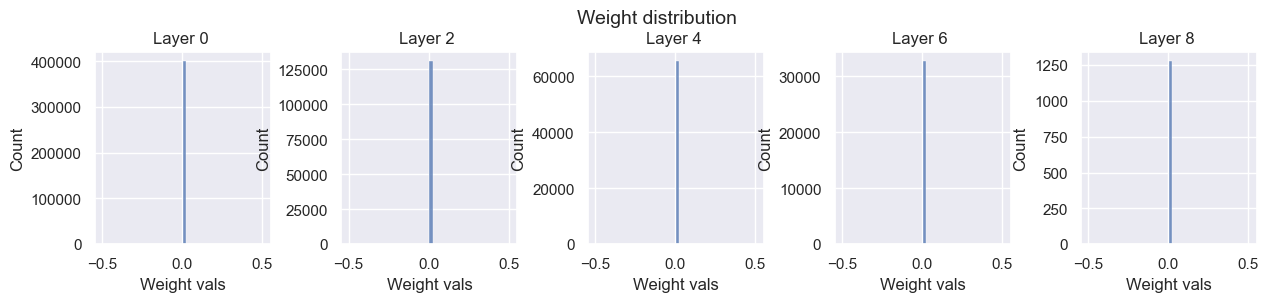

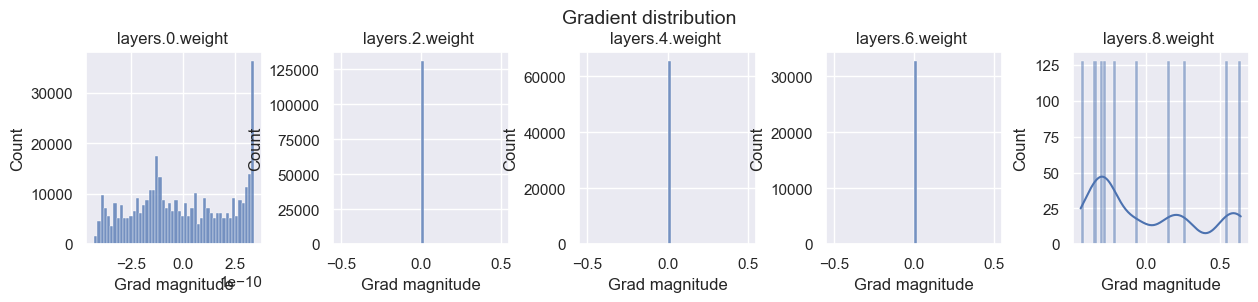

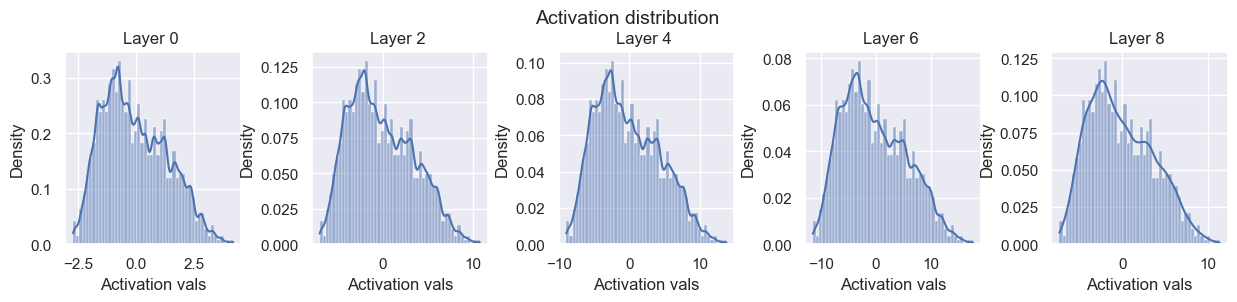

Layer 0 - Variance: 1.9506410360336304
Layer 2 - Variance: 12.783716201782227
Layer 4 - Variance: 20.944843292236328
Layer 6 - Variance: 34.31603240966797
Layer 8 - Variance: 14.05584716796875


In [21]:
def const_init(model, c=0.0):
    """ 定数値による重みの初期化

    Args:
        model (object): 重み
        c (float): 初期化する定数値. Defaults to 0.0.
    """
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
visualize_weight_distribution(model)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

#### 一定の分散を持つ分布からのサンプリング

ここでは、一定の分散を持つガウス分布からのサンプリングを行ってみます。

標準偏差=0.01を指定すると、勾配、活性化度ともに層を重ねると共にどんどん小さくなっていることがわかります。

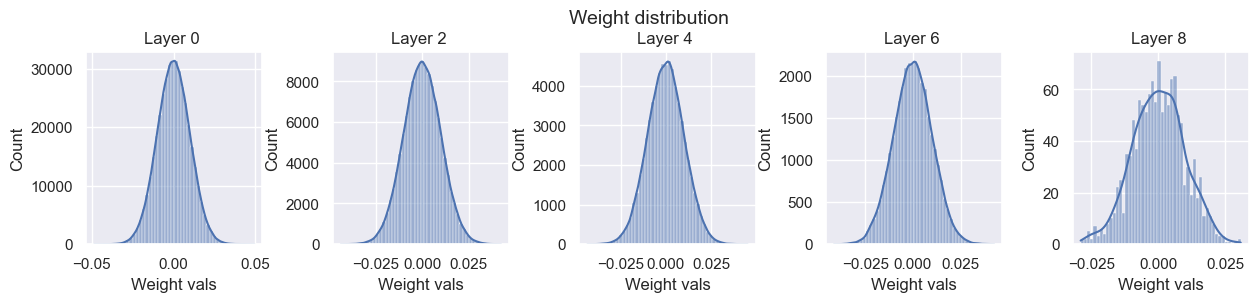

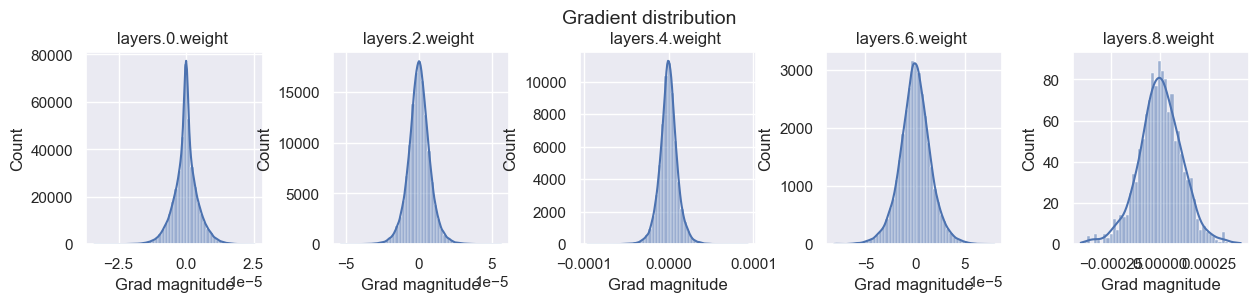

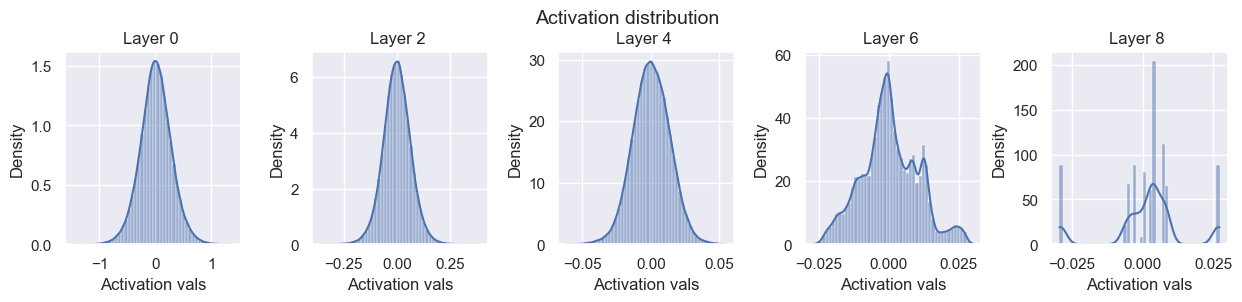

Layer 0 - Variance: 0.07737994194030762
Layer 2 - Variance: 0.004161748569458723
Layer 4 - Variance: 0.0001815276627894491
Layer 6 - Variance: 0.00010190998727921396
Layer 8 - Variance: 0.0001733367535052821


In [20]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)
        
var_init(model, std=0.01)
visualize_weight_distribution(model)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

次に標準偏差=0.1と大きくしてみます。  
こうすると、上記とは逆に活性化度と勾配が共に爆発的に増加しています。  
このように、毎回異なるネットワーク毎に適した標準偏差の値に変更することは非常に難しいです。  
このため、一定の標準偏差も良くない方法そうです。

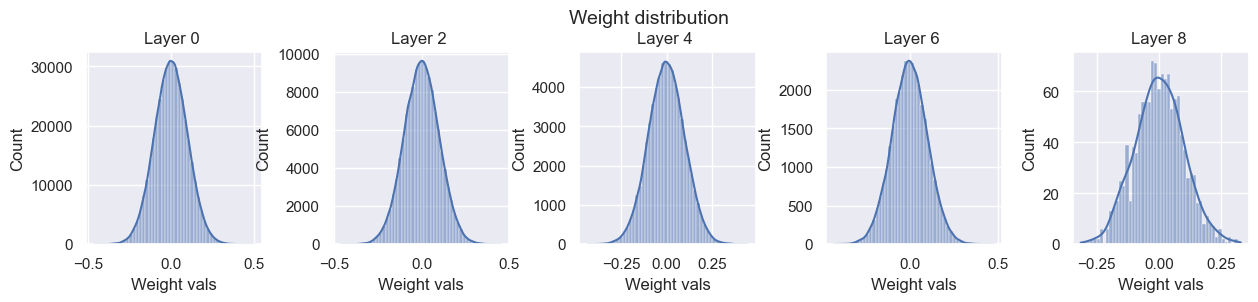

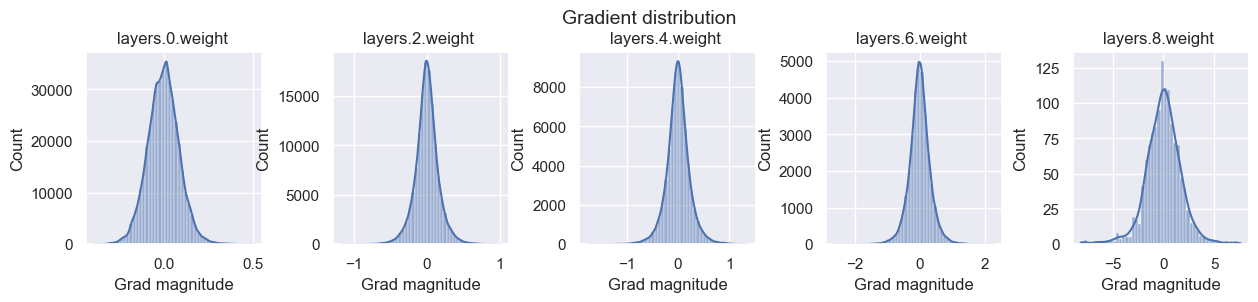

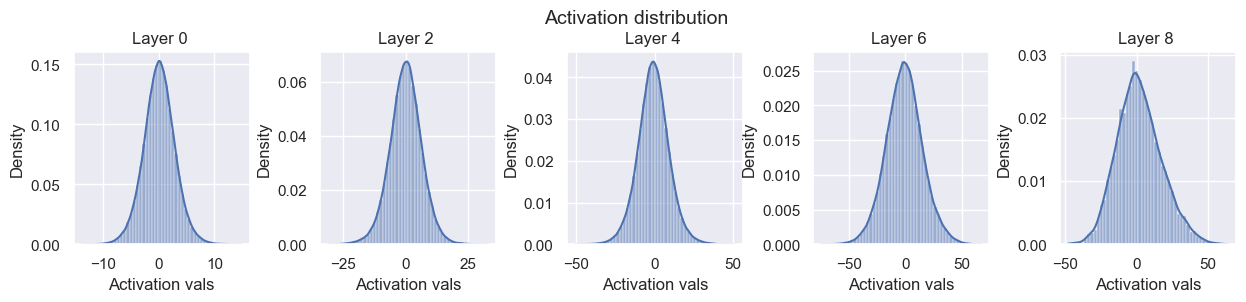

Layer 0 - Variance: 7.856950283050537
Layer 2 - Variance: 40.029666900634766
Layer 4 - Variance: 98.53602600097656
Layer 6 - Variance: 259.50823974609375
Layer 8 - Variance: 244.11190795898438


In [22]:
var_init(model, std=0.1)
visualize_weight_distribution(model)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

#### Xavierの初期化

以上の結果から低数値ではなく、何かしらの分布からサンプリングする必要はありそうです。

適切な初期化のためには、活性化度の分布としては以下の２点が求められます。

1. 活性化度分布の平均が０であること
2. 活性化度分布の分散が各層で同じであること

ここで、まずは以下のbias=0の線形層の初期化を考えたいとします。これは、NNの中の１つの層を抽出しているのと同じです。

$$
y_i = \sum_j{w_{ij} x_j}
$$

ここでのゴールは、入力の分散と出力の分散が同じになることです。ここで、$x$と$y$の平均は０としています。  
そうすると、以下のように計算を行うことができ、期待される重みの分散を計算することができます。  
ここで、$dim_x$は入力Xの次元数です。

\begin{align}
Var(y_i) = \sigma_x^2 &= Var(\sum_j{w_{ij} x_j}) \\
&= \sum_j{Var(w_{ij} x_j)} \\
&= \sum_j{E(w_{ij}^2)E(x_j^2) - E(w_{ij})^2E(x_j)^2} \\
&= \sum_j{Var(w_{ij})Var(x_j)} \\
&= dim_x Var(w_{ij})Var(x_j) \\
&= dim_x \sigma_x^2 Var(w_{ij}) 
\end{align}

$$
Var(w_{ij}) = \frac{1}{dim_x}
$$

以下の結果を確認すると、期待通り活性化度の分散は層を跨いで同じ程度であることがわかります。しかし、勾配の分散を見ると大きく変わってしまっていることがわかります。

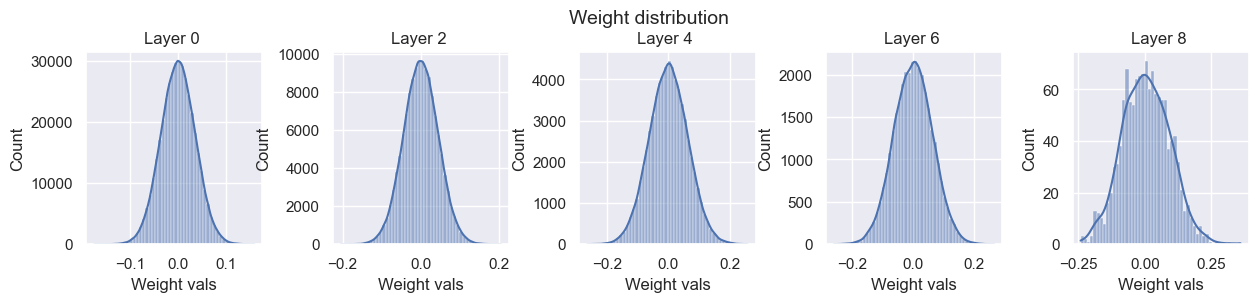

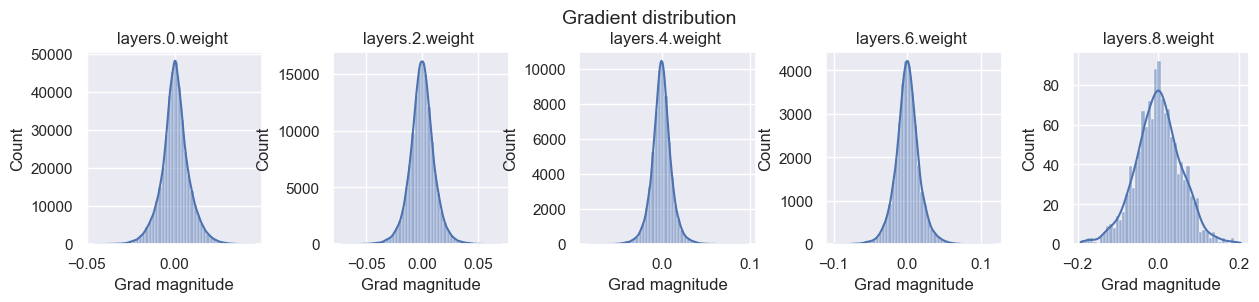

layers.0.weight - Variance: 6.382750143529847e-05
layers.2.weight - Variance: 0.00012239917123224586
layers.4.weight - Variance: 0.00013141277304384857
layers.6.weight - Variance: 0.0002700120967347175
layers.8.weight - Variance: 0.003308443818241358


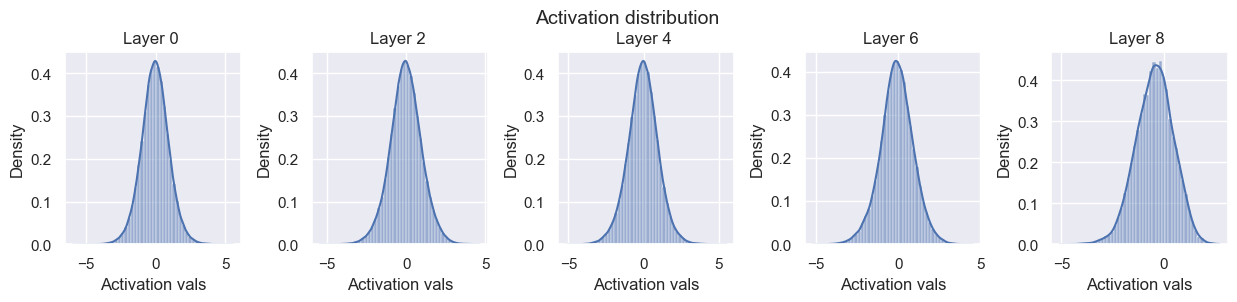

Layer 0 - Variance: 0.9778083562850952
Layer 2 - Variance: 0.9896291494369507
Layer 4 - Variance: 1.004972219467163
Layer 6 - Variance: 1.0187735557556152
Layer 8 - Variance: 0.8414148092269897


In [25]:
def equal_var_init(model):
    """ bias=0, weightsはstd=1/dxからサンプリングする初期化関数

    Args:
        model (object): モデル
    """
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0/math.sqrt(param.shape[1]))
        
equal_var_init(model)
visualize_weight_distribution(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

活性化度の分散の他に、勾配の分散も安定化したいです。こちらも上記と同様の計算を行うことで$\frac{1}{dim_y}$で初期化すれば良いことがわかります。ここで、$\frac{1}{dim_y}$は出力のニューロン数です。  
この２つの妥協点として提案された調和平均を取った手法が以下のXavierの初期化です。

$$
W = N(0, \frac{2}{d_x+d_y})
$$

分布は正規分布である必要はないので、稀な小さい/大きい値を避けるために一様分布が使われる場合もあります。

$$
W = U(-\frac{\sqrt{6}}{\sqrt{d_x+d_y}}, \frac{\sqrt{6}}{\sqrt{d_x+d_y}})
$$

以下の結果を見ると、勾配と活性化度の分散の安定性がうまくバランスが取れていることがわかります。

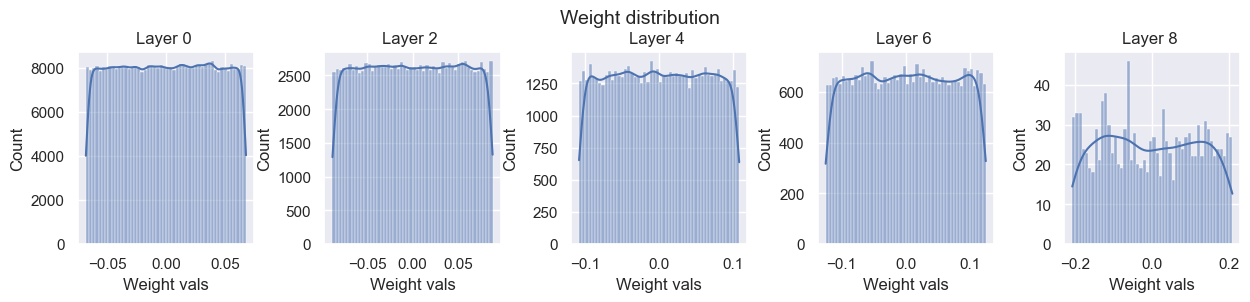

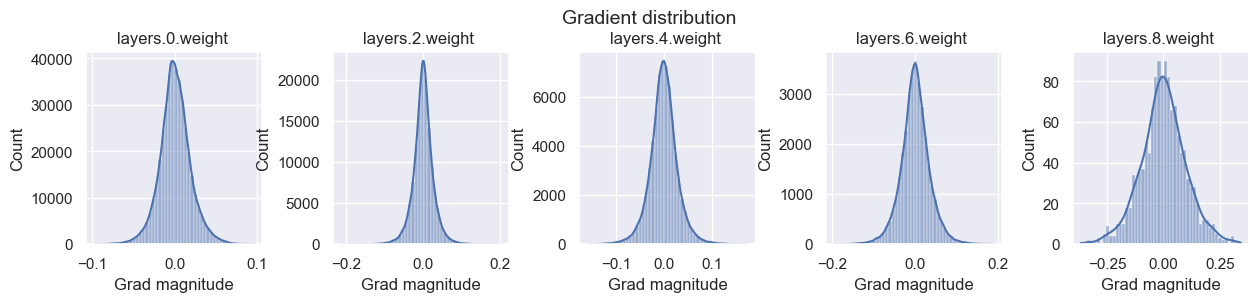

layers.0.weight - Variance: 0.00035375668085180223
layers.2.weight - Variance: 0.0006962635088711977
layers.4.weight - Variance: 0.0008229253580793738
layers.6.weight - Variance: 0.0012200374621897936
layers.8.weight - Variance: 0.010058209300041199


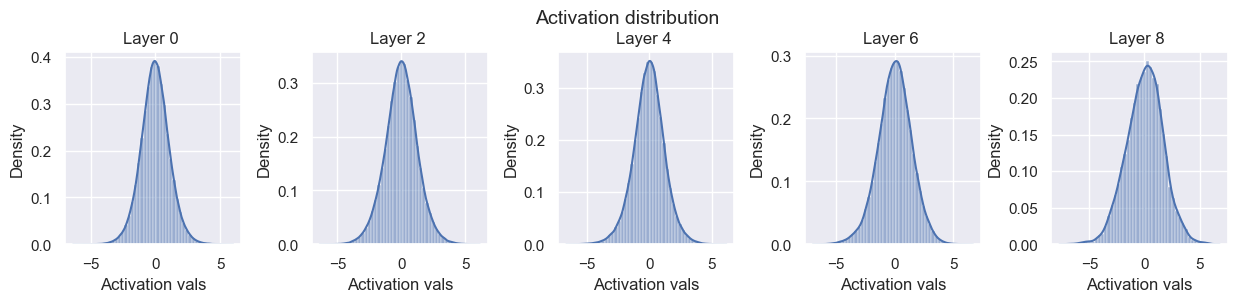

Layer 0 - Variance: 1.2058995962142944
Layer 2 - Variance: 1.5996441841125488
Layer 4 - Variance: 1.5593585968017578
Layer 6 - Variance: 2.076493978500366
Layer 8 - Variance: 2.792454957962036


In [28]:
def xavier_init(model):
    """ Xavierの初期化

    Args:
        model (object): モデル
    """
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
            param.data.uniform_(-bound, bound)
        
xavier_init(model)
visualize_weight_distribution(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

上記はIdentity関数に関してでしたが、次は非線形関数の``Tanh``を試してみます。  
以下の結果を見ると、勾配の分散は次第に減少はしていますが、低めの値で安定しています。

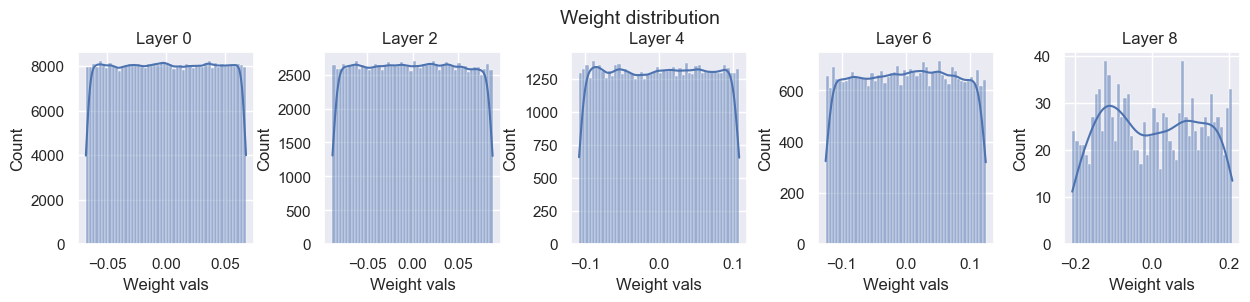

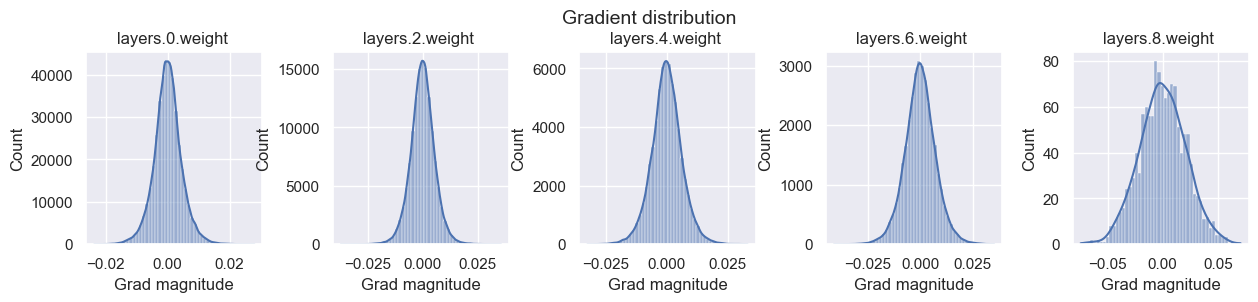

layers.0.weight - Variance: 1.9824230548692867e-05
layers.2.weight - Variance: 2.957240394607652e-05
layers.4.weight - Variance: 3.850640860036947e-05
layers.6.weight - Variance: 5.425118433777243e-05
layers.8.weight - Variance: 0.0004411475674714893


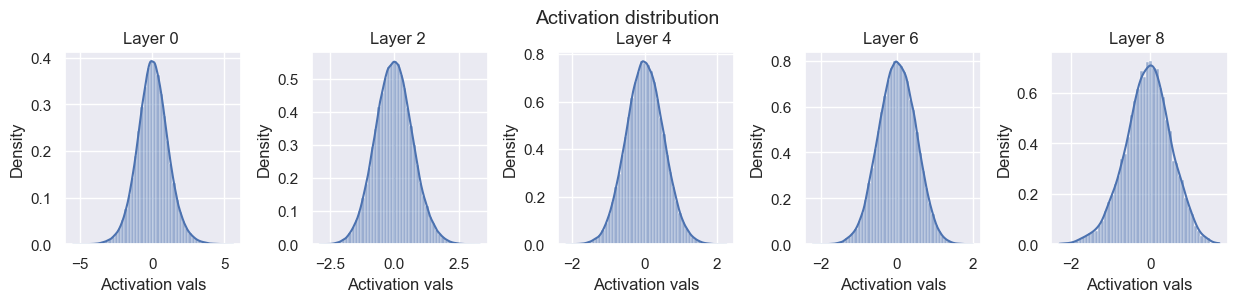

Layer 0 - Variance: 1.1773738861083984
Layer 2 - Variance: 0.5227447748184204
Layer 4 - Variance: 0.2666252851486206
Layer 6 - Variance: 0.23797526955604553
Layer 8 - Variance: 0.33757656812667847


In [29]:
model = BaseNetwork(act_fn=nn.Tanh).to(device)
xavier_init(model)
visualize_weight_distribution(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

#### Kaimingの初期化

次は、``ReLU``を試します。ReLUの場合、$x_i$は非負の値を持つため、上記の$E(x_i)=0$が満たされないです。そのため、ReLUを使用する場合は、重みの期待値を０の場合を考えます。そうすると出力の期待値も０と考えられるようになり、以下のように求めることができます。

\begin{align}
Var(y_i) = \sigma_x^2 &= Var(\sum_j{w_{ij} x_j}) \\
&= \sum_j{Var(w_{ij} x_j)}  \\
&= \sum_j{E(w_{ij}^2)E(x_j^2) - E(w_{ij})^2E(x_j)^2} \\
&= \sum_j{Var(w_{ij})E(x_j^2)} \\
&= dim_x Var(w_{ij}) \frac{1}{2}Var(\tilde{y})  
\end{align}

ここで、前の層と後の層で出力の分散が同じであることを要請すると、以下のように導くことができます。

$$
Var(w_{ij}) = \frac{2}{dim_x}
$$

ここで、前の層の出力から$x$は$x = max(0, \tilde{y})$のように表すことと$\tilde{y}$が0中心で対称性を持つことを使用しました。
$$
E(x_i^2) = E(max(0, \tilde{y})^2) = \frac{1}{2}E(\tilde{y}^2) =  \frac{1}{2}Var(\tilde{y}) 
$$


この初期化を行うことで、分散は安定していることがわかります。ここで、前回の活性化関数でReLUの派生を使用しましたが、Leakly ReLUなどでは係数２を調整する必要があるみたいです。（torch.nn.init.calculate_gain, https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain）

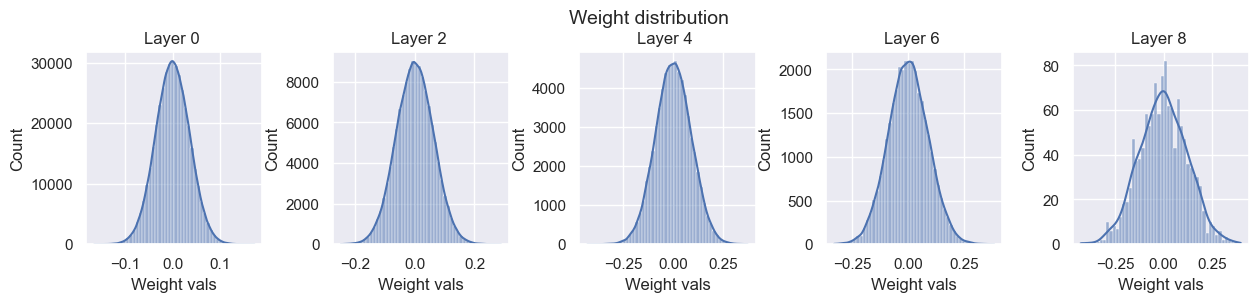

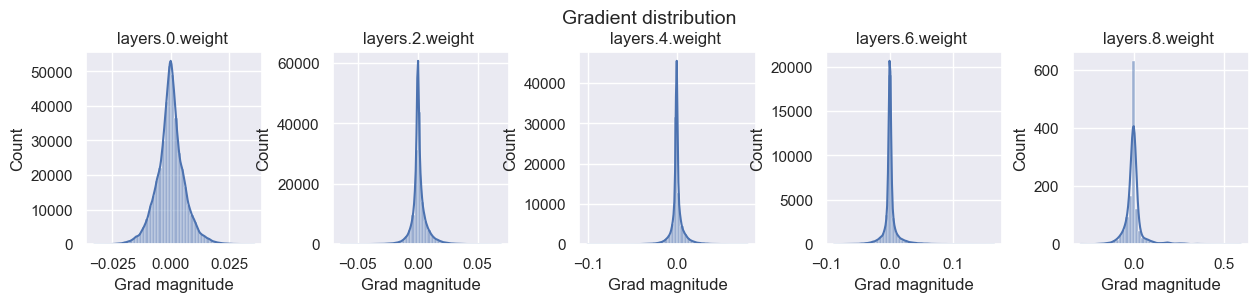

layers.0.weight - Variance: 3.5574314097175375e-05
layers.2.weight - Variance: 4.537825952866115e-05
layers.4.weight - Variance: 6.0824422689620405e-05
layers.6.weight - Variance: 0.0001723201130516827
layers.8.weight - Variance: 0.0029762324411422014


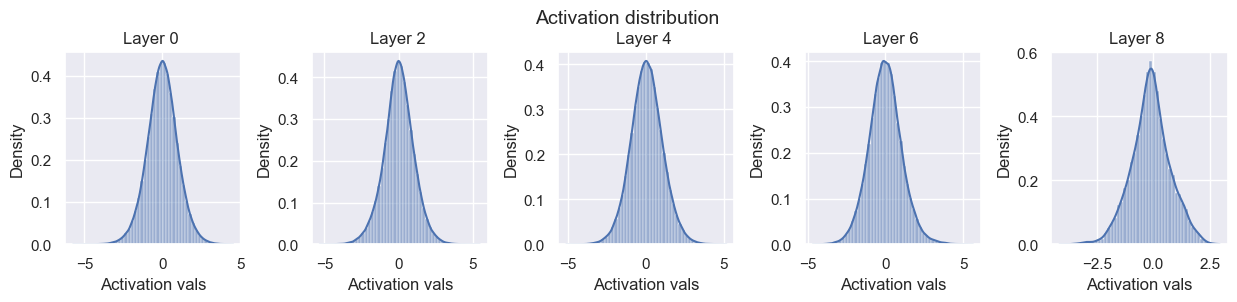

Layer 0 - Variance: 0.9592753052711487
Layer 2 - Variance: 1.0194153785705566
Layer 4 - Variance: 1.0559827089309692
Layer 6 - Variance: 1.1198415756225586
Layer 8 - Variance: 0.7481290102005005


In [31]:
def kaiming_init(model):
    """ Kaimingの初期化

    Args:
        model (object): モデル
    """
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"):
             # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))

model = BaseNetwork(act_fn=nn.ReLU).to(device)
kaiming_init(model)
visualize_weight_distribution(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

ReLUでxavierの初期化を以下で試してみます。上記のXamingの初期化と比較すると、活性化度の値の分散が特に安定していないように見えます。

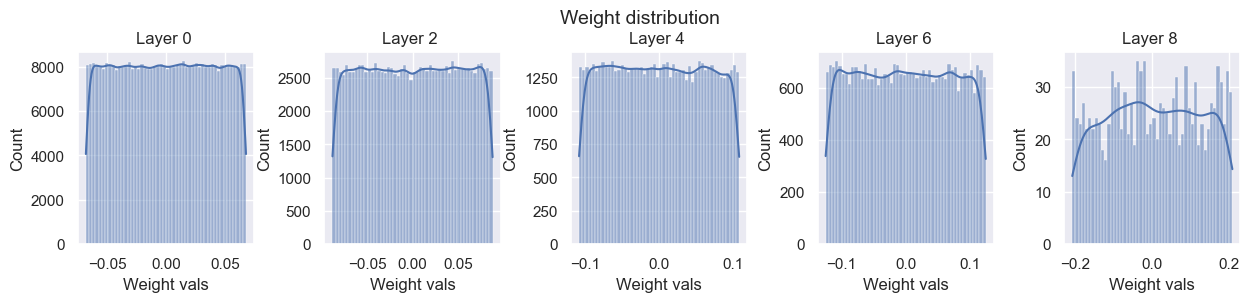

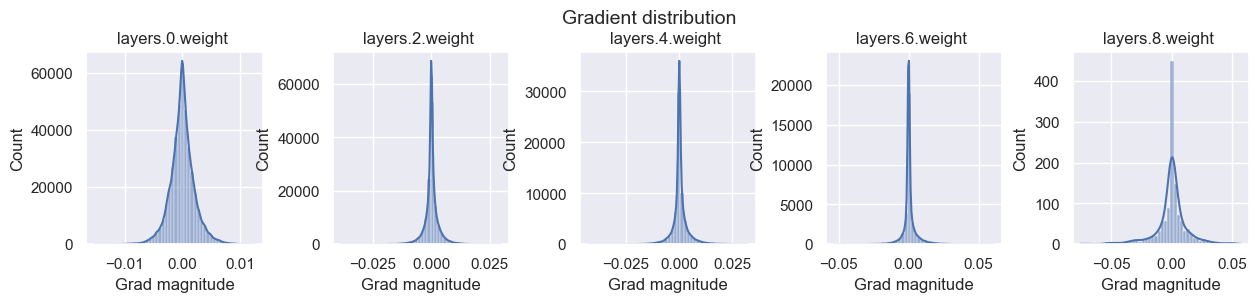

layers.0.weight - Variance: 4.6040231609367765e-06
layers.2.weight - Variance: 9.450764991925098e-06
layers.4.weight - Variance: 1.44968962558778e-05
layers.6.weight - Variance: 2.4902266886783764e-05
layers.8.weight - Variance: 0.0001871339336503297


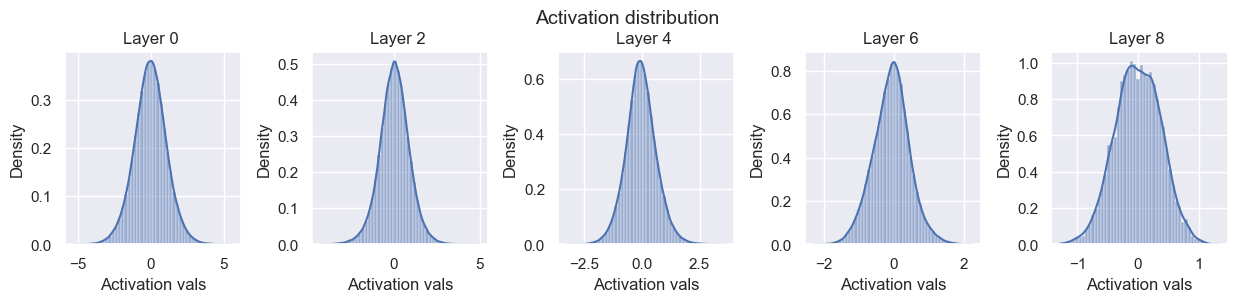

Layer 0 - Variance: 1.2283973693847656
Layer 2 - Variance: 0.7428175210952759
Layer 4 - Variance: 0.4391724169254303
Layer 6 - Variance: 0.2707046866416931
Layer 8 - Variance: 0.14129725098609924


In [33]:
model = BaseNetwork(act_fn=nn.ReLU).to(device)
xavier_init(model)
visualize_weight_distribution(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

以上で、初期化は終わりです。